In [143]:


import torch
import numpy as np
%load_ext autoreload
%autoreload 2
import pinot
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
# define the target
f = lambda x: torch.sin(x)

x_tr = torch.tensor(np.concatenate(
    [
        np.linspace(-3 * math.pi, -math.pi, 50),
        np.linspace(math.pi, 3 * math.pi, 50)
    ]),
    dtype=torch.float32)[:, None]

x_te = torch.tensor(np.concatenate(
    [
        np.linspace(-7 * math.pi, -3 * math.pi, 100),
        np.linspace(-math.pi, math.pi, 50),
        np.linspace(3 * math.pi, 7 * math.pi, 100)
    ]),
    dtype=torch.float32)[:, None]

x = torch.tensor(np.linspace(-7 * math.pi, 7 * math.pi, 375),
                 dtype=torch.float32)[:, None]


y_tr = f(x_tr)
y_te = f(x_te)
y = f(x)

In [145]:
net = torch.nn.Sequential(
        torch.nn.Linear(1, 50),
        torch.nn.Tanh())

base_kernel=pinot.inference.gp.kernels.rbf.RBF()

kernel = pinot.inference.gp.kernels.deep_kernel.DeepKernel(
    net,
    base_kernel=base_kernel)

gpr = pinot.inference.gp.gpr.sparse_variational_gpr.SVGPR(
    kernel, 
    n_inducing_points=10,
    in_features=50)

In [146]:
opt = torch.optim.Adam(gpr.parameters(), 1e-2)
for _ in range(5000):
    opt.zero_grad()
    loss = gpr.loss(x_tr, y_tr).sum()
    loss.backward()
    print(loss)
    opt.step()

m_all torch.Size([100, 10])
L torch.Size([100, 100])


RuntimeError: The size of tensor a (100) must match the size of tensor b (10) at non-singleton dimension 1

In [23]:
gpr.mu

Parameter containing:
tensor([-0.4296, -0.4317, -0.4340, -0.4364, -0.4402, -0.4450, -0.4473, -0.4517,
        -0.4525, -0.4536, -0.4513, -0.4477, -0.4407, -0.4294, -0.4160, -0.3990,
        -0.3773, -0.3509, -0.3201, -0.2866, -0.2493, -0.2072, -0.1619, -0.1133,
        -0.0619, -0.0115,  0.0403,  0.0937,  0.1495,  0.2009,  0.2495,  0.2954,
         0.3389,  0.3774,  0.4148,  0.4472,  0.4731,  0.4937,  0.5095,  0.5177,
         0.5226,  0.5207,  0.5133,  0.5016,  0.4821,  0.4588,  0.4286,  0.3977,
         0.3717,  0.3525, -0.3582, -0.3827, -0.4211, -0.4648, -0.5148, -0.5604,
        -0.5989, -0.6367, -0.6618, -0.6809, -0.6924, -0.6935, -0.6802, -0.6626,
        -0.6362, -0.5968, -0.5496, -0.4964, -0.4384, -0.3739, -0.3080, -0.2386,
        -0.1686, -0.0987, -0.0312,  0.0355,  0.0999,  0.1611,  0.2186,  0.2714,
         0.3217,  0.3657,  0.4058,  0.4406,  0.4694,  0.4938,  0.5097,  0.5212,
         0.5279,  0.5283,  0.5273,  0.5230,  0.5172,  0.5093,  0.4980,  0.4855,
         0.4732,  

In [24]:
gpr.condition(x_tr, y_tr, x_te)

MixtureSameFamily(
  Categorical(probs: torch.Size([100]), logits: torch.Size([100])),
  MultivariateNormal(loc: torch.Size([100, 250]), covariance_matrix: torch.Size([100, 250, 250])))

In [25]:
y_hat_distribution = gpr.condition(x_tr, y_tr, x)


In [26]:
y_hat_distribution.sample().shape

torch.Size([375])

In [27]:
def plot():
    from pinot.inference.utils import confidence_interval
    from matplotlib import pyplot as plt

    plt.figure(figsize=(10, 6))
    # y_hat_distribution = pinot.inference.utils.condition_mixture(net, x, sampler=opt, n_samples=1000)

    nll = y_hat_distribution.log_prob(y).mean() / float(y.shape[0])

    plt.plot(x, y_hat_distribution.mean.detach().numpy(), c='k', linewidth=5)

    low, high = confidence_interval(y_hat_distribution, 0.95, n_samples=10)
    plt.fill_between(x.flatten(), low.flatten().detach(), high.flatten().detach(), color='k', alpha=0.1)
    
    low, high = confidence_interval(y_hat_distribution, 0.75, n_samples=10)
    plt.fill_between(x.flatten(), low.flatten().detach(), high.flatten().detach(), color='k', alpha=0.2)

    low, high = confidence_interval(y_hat_distribution, 0.50, n_samples=10)
    plt.fill_between(x.flatten(), low.flatten().detach(), high.flatten().detach(), color='k', alpha=0.3)

    low, high = confidence_interval(y_hat_distribution, 0.25, n_samples=10)
    plt.fill_between(x.flatten(), low.flatten().detach(), high.flatten().detach(), color='k', alpha=0.4)

    plt.scatter(x_te, y_te, label='te')
    plt.scatter(x_tr, y_tr, label='tr')
    plt.legend()
    plt.ylim(-2, 2)
    plt.title('NLL=%s' % nll.detach().numpy().round(3))

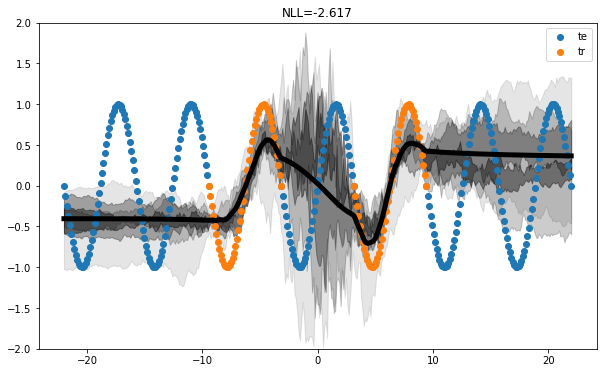

In [28]:
plot()